<a href="https://colab.research.google.com/github/Vinoth11111/A-B-Testing-Nykaa/blob/main/nykaa_a_b_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [44]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random

In [45]:
np.random.seed(190)

In [46]:
groups = ['control','treatment']
df = pd.DataFrame({'user_id': range(1,100001),
                   'group': random.choices(groups,k=100000),
                   'converted': 0,
                   'order_value': 0
                   })

In [47]:
df['group'].value_counts()

,count
group,
treatment,50120
control,49880


In [48]:
df

,user_id,group,converted,order_value
0,1,treatment,0,0
1,2,control,0,0
2,3,control,0,0
3,4,treatment,0,0
4,5,treatment,0,0
...,...,...,...,...
99995,99996,control,0,0
99996,99997,treatment,0,0
99997,99998,treatment,0,0
99998,99999,treatment,0,0


In [49]:
def conversion(df):
  control = df['group'] == 'control'
  treatment = df['group'] == 'treatment'
  df.loc[control,'converted'] = np.random.binomial(1,0.03,control.sum())
  df.loc[treatment,'converted'] = np.random.binomial(1,0.028,treatment.sum())
  return df

In [50]:
df = conversion(df)

In [51]:
df

,user_id,group,converted,order_value
0,1,treatment,0,0
1,2,control,0,0
2,3,control,0,0
3,4,treatment,0,0
4,5,treatment,0,0
...,...,...,...,...
99995,99996,control,0,0
99996,99997,treatment,0,0
99997,99998,treatment,0,0
99998,99999,treatment,0,0


In [52]:
df['converted'].value_counts()

,count
converted,
0,97056
1,2944


In [53]:
def coversion_cal(df):
  contorl_con = df['converted'].loc[(df['group'] == 'control')]
  treatment_con = df['converted'].loc[(df['group'] == 'treatment')]
  control_conversion_rate = contorl_con.mean()
  treatment_conversion_rate = treatment_con.mean()
  return control_conversion_rate,treatment_conversion_rate


In [54]:
control_conversion_rate,treatment_conversion_rate = coversion_cal(df)
print('conversion rate of control is ',control_conversion_rate)
print('conversion rate of treatment is ',treatment_conversion_rate)

conversion rate of control is  0.030713712910986367
conversion rate of treatment is  0.02817238627294493


In [55]:
def add_order_value(df):
  control = df['group'] == 'control'
  treatment = df['group'] == 'treatment'
  control_conversion = df['converted'].loc[df['group'] == 'control'].sum()
  treatment_conversion = df['converted'].loc[df['group'] == 'treatment'].sum()
  sigma = 0.5
  df['order_value'].loc[(control) & (df['converted'] == 1)] = np.random.lognormal(mean=np.log(550)- (sigma**2/2),sigma=sigma,size = control_conversion)
  df['order_value'].loc[(treatment) & (df['converted'] == 1)] = np.random.lognormal(mean=np.log(610)-(sigma**2/2),sigma = sigma,size = treatment_conversion)
  return df

In [56]:
df = add_order_value(df)

/tmp/ipython-input-29461142.py:7: FutureWarning: ChainedAssignmentError: behaviour will change in pandas 3.0!
You are setting values through chained assignment. Currently this works in certain cases, but when using Copy-on-Write (which will become the default behaviour in pandas 3.0) this will never work to update the original DataFrame or Series, because the intermediate object on which we are setting values will behave as a copy.
A typical example is when you are setting values in a column of a DataFrame, like:

df["col"][row_indexer] = value

Use `df.loc[row_indexer, "col"] = values` instead, to perform the assignment in a single step and ensure this keeps updating the original `df`.

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

  df['order_value'].loc[(control) & (df['converted'] == 1)] = np.random.lognormal(mean=np.log(550)- (sigma**2/2),sigma=sigma,size = control_conversion)
/tmp/ipytho

In [57]:
df.loc[df['converted'] == 1]

,user_id,group,converted,order_value
61,62,control,1,592.684416
94,95,control,1,241.233863
132,133,treatment,1,208.970063
163,164,treatment,1,246.151274
211,212,treatment,1,494.694501
...,...,...,...,...
99889,99890,treatment,1,402.359423
99934,99935,control,1,132.976904
99936,99937,control,1,574.077128
99960,99961,treatment,1,384.482636


In [58]:
aov_control = df['order_value'].loc[(df['group']=='control') & (df['converted'] == 1)].mean()
aov_treatment = df['order_value'].loc[(df['group']=='treatment') & (df['converted'] == 1)].mean()


In [59]:
print('average order value for control users is ', aov_control)
print('average order value for treatment users is ', aov_treatment)

average order value for control users is  552.1704496521448
average order value for treatment users is  613.4753800977707


In [60]:
df.reset_index(drop=True).to_csv('nykaa_ab_testing_dataset')

In [61]:
#let us assumes that we dont know anything about the data like conversion rate,aov etc
# conversion rate for both control and treatment.
control_conversion,treatment_conversion = df.groupby('group')['converted'].mean()

In [62]:
print(f'control conversion is {control_conversion*100:.3f}')
print(f'treatment conversion is {treatment_conversion*100:.3f}')

control conversion is 3.071
treatment conversion is 2.817


In [63]:
# average order value for each group,
# average order value is our metrics that we want to increase.
aov_control,aov_treatment = df[df['converted']==1].groupby('group')['order_value'].mean()

In [64]:
print(f'average order value in control group is {aov_control:.3f}')
print(f'average order value in treatment group is {aov_treatment:.3f}')

average order value in control group is 552.170
average order value in treatment group is 613.475


In [65]:
#Revernue per user,
# revenue per user is the guardrail metric that we want to take care of.
revenue_control,revenue_treatment = df.groupby('group')['order_value'].mean()

In [66]:
print(f'revenue per user in control group is {revenue_control:.3f}')
print(f'revenue per user in treatment group is {revenue_treatment:.3f}')

revenue per user in control group is 16.959
revenue per user in treatment group is 17.283


In [67]:
control_group = df[df['group'] == 'control']
treatment_group = df[df['group'] == 'treatment']

In [68]:
from scipy.stats import ttest_ind
from scipy.stats import shapiro
from scipy.stats import chi2_contingency

In [69]:
#checking for normal distribution,because the t_test assumes normal distribution.
stat,p_value = shapiro(control_group['order_value'])
print(f'p_value is {p_value:.3f}')
stat, p_value = shapiro(treatment_group['order_value'])
print(f"Treatment group normality p-value: {p_value}")

p_value is 0.000
Treatment group normality p-value: 5.883311527958109e-159


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 49880.
  res = hypotest_fun_out(*samples, **kwds)
/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 50120.
  res = hypotest_fun_out(*samples, **kwds)


<Axes: xlabel='order_value', ylabel='Density'>

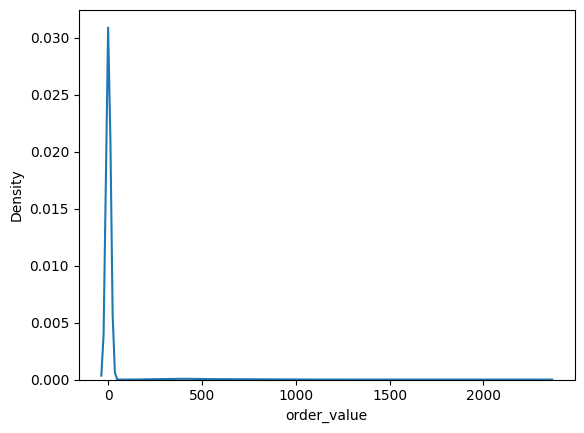

In [70]:
# since only small amount of the pepople convert we get positive kurtosis and not a normal distribution.
sns.kdeplot(control_group['order_value'])

<Axes: xlabel='order_value', ylabel='Density'>

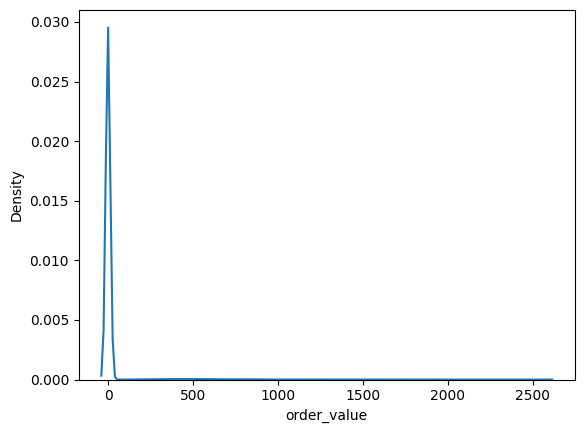

In [71]:
sns.kdeplot(treatment_group['order_value'],label='treatment')


In [72]:
#both p_value and distribution plot tells us right now our data is not normaly distributed .
# so we can't use t-test, because t_test assumes normal distribution.(but we can use them)

In [73]:
# if the data is even not normaly distributed, when the data is n> 50, we can use the t_test
# we trust centrel limit theorem.(n>50000)
# but we have to make sure we dont have any outliers in the data, because it alter mean of the group. t_test requries mean

In [82]:
print('control max value ',control_group['order_value'].max())
print('control min value ',control_group['order_value'].min())
print('treatment_group max value ',treatment_group['order_value'].max())
print('treatment_group min value ',treatment_group['order_value'].min())


control max value  2329.846915962757
control min value  0.0
treatment_group max value  2574.0917417757646
treatment_group min value  0.0


{'whiskers': [<matplotlib.lines.Line2D at 0x781aa2fc4da0>,
 'caps': [<matplotlib.lines.Line2D at 0x781aa2fc4350>,
 'boxes': [<matplotlib.lines.Line2D at 0x781aa300a6f0>],
 'medians': [<matplotlib.lines.Line2D at 0x781aa2fc6e40>],
 'fliers': [<matplotlib.lines.Line2D at 0x781aa2fc4740>],
 'means': []}

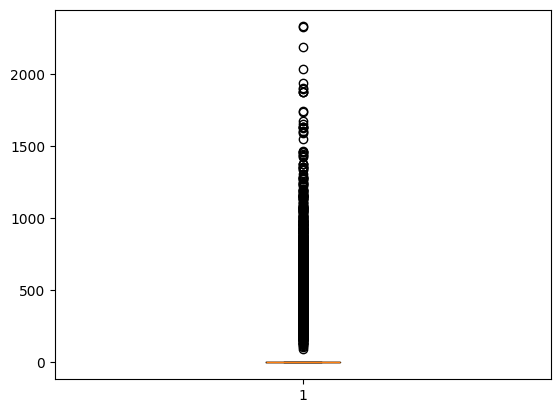

In [84]:
plt.boxplot(control_group['order_value'])

In [83]:
print('control avg value ',control_group['order_value'].mean())
print('control avg value ',treatment_group['order_value'].mean())


control avg value  16.959204668546228
control avg value  17.28306537705611


In [81]:
# we are setting, equal variance = False, because it reduce one assumption,
# it change the default student t_test  to welch's t_test.
# welch's t_test assumes that there is no need for equal variance.it assumes only normal distribution.(from above plot and the max values, their likely unequal variance)
# in our case that, in treatment group people trend to spend more so ,its safe to use welch's t_test.

stat_value,p_value = ttest_ind(control_group['order_value'],treatment_group['order_value'],equal_var=False,alternative='two-sided')
print(f'p_value is {p_value:.3f}')
alpha = 0.05
if p_value < alpha:
  print('we reject the null hypothesis,there is statistical significants')
else:
  print('we fail to reject the null hypothesis,there is a no statistical significants')

p_value is 0.646
we fail to reject the null hypothesis,there is a no statistical significants


In [75]:
stat_value

np.float64(-0.45964933019304727)

as we can see from p_value(0.64) there is no statistical significant between control and treatment. and if the null hypothesis is true we expect to see 64% of the times just by random(luck🍀).

right now our stats value for test is -0.45, which means that the signal is very small compared to the  noice which does not create enough evidence to see the statistical difference.

# mean difference between control and treatment is only 0.45% of the noice, noice very high will lead to submerge the mean difference

stats_value = mean diff in the group/standard error

variance diff in the group = mean of control - mean of treatment

#here we have negative value which mean treatment variance is higher than control variance.

if the range is bound greater than -2.4 or 3.1(imagenary) we will have p_value < 0.05. stats_value find the evidence and for p_value, if stats value is huge the P_value will be less, lead to alternative hypothesis

In [76]:
chi_data = pd.crosstab(df['group'],df['converted'])
chi_data

converted,0,1
group,,
control,48348,1532
treatment,48708,1412


In [77]:
# chi-square test tell us is there any significant in the conversion
chi2,p_val,dof,expected = chi2_contingency(chi_data)
print(f'p_value is {p_val:.3f}')
alpha = 0.05
if p_val < alpha:
  print('there is a statistical significant difference in conversion rate between both control and treatment group')
else:
  print('conversion rate same for control and treatment group')

p_value is 0.018
there is a statistical significant difference in conversion rate between both control and treatment group


In [78]:
print(chi2) #how much observed values devited from actual values.
# here we have 5 which is moderate deviation.

5.5620577984658315


In [79]:
dof # dof = no of row -1 * no of col-1 2-1 * 2-1 = 1, its used for calculating p_value

1

In [80]:
expected # expected value if both treatment and control have same conversion rate.

array([[48411.5328,  1468.4672],
       [48644.4672,  1475.5328]])